<a href="https://colab.research.google.com/github/38tter/nishika-second-hand-apartment-price-forecasting-2022-winter/blob/main/base_and_fill_na_and_aggregation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

from google.colab import files
files.upload()

Saving data.zip to data.zip


In [ ]:
import zipfile
with zipfile.ZipFile('data.zip') as z:
  z.extractall()

In [ ]:
import zipfile
with zipfile.ZipFile('train.zip') as z:
  z.extractall()

In [ ]:
!ls

data_explanation.xlsx  __MACOSX     sample_submission.csv  train
data.zip	       sample_data  test.csv		   train.zip


In [ ]:
from glob import glob
import pandas as pd

paths = glob('./train/*')
train_dfs = []
for path in paths:
    train_df = pd.read_csv(path)
    train_dfs.append(train_df)
train_df = pd.concat(train_dfs)
train_df.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
test_df = pd.read_csv('./test.csv')

In [ ]:
test_df.head()

,ID,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等
0,1000001,中古マンション等,NaN,1101,北海道,札幌市中央区,旭ケ丘,円山公園,25,４ＬＤＫ,85,NaN,NaN,NaN,昭和64年,ＲＣ,NaN,住宅,NaN,NaN,NaN,第１種低層住居専用地域,40.0,80.0,2021年第1四半期,未改装,NaN
1,1000002,中古マンション等,NaN,1101,北海道,札幌市中央区,旭ケ丘,円山公園,20,４ＬＤＫ,105,NaN,NaN,NaN,平成9年,ＲＣ,NaN,住宅,NaN,NaN,NaN,近隣商業地域,80.0,200.0,2021年第1四半期,未改装,NaN
2,1000066,中古マンション等,NaN,1101,北海道,札幌市中央区,大通西,西１１丁目,3,２ＬＤＫ,50,NaN,NaN,NaN,平成24年,ＲＣ,NaN,住宅,NaN,NaN,NaN,商業地域,80.0,600.0,2021年第1四半期,未改装,NaN
3,1000119,中古マンション等,NaN,1101,北海道,札幌市中央区,大通西,西１８丁目,2,１ＬＤＫ,45,NaN,NaN,NaN,平成3年,ＳＲＣ,NaN,住宅,NaN,NaN,NaN,商業地域,80.0,400.0,2021年第1四半期,未改装,NaN
4,1000120,中古マンション等,NaN,1101,北海道,札幌市中央区,大通西,西１８丁目,4,２ＬＤＫ,55,NaN,NaN,NaN,昭和55年,ＳＲＣ,NaN,住宅,NaN,NaN,NaN,近隣商業地域,80.0,300.0,2021年第1四半期,未改装,NaN


In [ ]:
# すべての行が NaN のカラムを抽出する
line_length = len(train_df)
drop_columns = [val for val in train_df.isnull().sum().keys() if train_df[val].isnull().sum() == line_length]

['I', 'D']

In [ ]:
train_df = train_df.drop(drop_columns, axis=1)

In [ ]:
test_df = test_df.drop(drop_columns, axis=1)

In [ ]:
na_contained_keys = [key for key in train_df.keys() if len(train_df[train_df[key].isnull()]) > 0]

In [ ]:
na_contained_keys

['地区名',
 '最寄駅：名称',
 '最寄駅：距離（分）',
 '間取り',
 '建築年',
 '建物の構造',
 '用途',
 '今後の利用目的',
 '都市計画',
 '建ぺい率（％）',
 '容積率（％）',
 '改装',
 '取引の事情等']

In [ ]:
train_df.drop('ID', axis=1)
test_df.drop('ID', axis=1)

,種類,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等
0,中古マンション等,1101,北海道,札幌市中央区,旭ケ丘,円山公園,25,４ＬＤＫ,85,昭和64年,ＲＣ,NaN,住宅,第１種低層住居専用地域,40.0,80.0,2021年第1四半期,未改装,NaN
1,中古マンション等,1101,北海道,札幌市中央区,旭ケ丘,円山公園,20,４ＬＤＫ,105,平成9年,ＲＣ,NaN,住宅,近隣商業地域,80.0,200.0,2021年第1四半期,未改装,NaN
2,中古マンション等,1101,北海道,札幌市中央区,大通西,西１１丁目,3,２ＬＤＫ,50,平成24年,ＲＣ,NaN,住宅,商業地域,80.0,600.0,2021年第1四半期,未改装,NaN
3,中古マンション等,1101,北海道,札幌市中央区,大通西,西１８丁目,2,１ＬＤＫ,45,平成3年,ＳＲＣ,NaN,住宅,商業地域,80.0,400.0,2021年第1四半期,未改装,NaN
4,中古マンション等,1101,北海道,札幌市中央区,大通西,西１８丁目,4,２ＬＤＫ,55,昭和55年,ＳＲＣ,NaN,住宅,近隣商業地域,80.0,300.0,2021年第1四半期,未改装,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22390,中古マンション等,47211,沖縄県,沖縄市,字美里,NaN,NaN,３ＬＤＫ,75,平成31年,ＲＣ,NaN,住宅,近隣商業地域,80.0,300.0,2021年第1四半期,未改装,NaN
22391,中古マンション等,47211,沖縄県,沖縄市,美里,NaN,NaN,２ＬＤＫ,65,平成30年,ＲＣ,住宅,住宅,第１種中高層住居専用地域,60.0,200.0,2021年第1四半期,未改装,NaN
22392,中古マンション等,47211,沖縄県,沖縄市,美原,NaN,NaN,３ＬＤＫ,65,平成22年,ＲＣ,住宅,住宅,近隣商業地域,80.0,300.0,2021年第1四半期,未改装,NaN
22393,中古マンション等,47211,沖縄県,沖縄市,与儀,NaN,NaN,NaN,60,平成29年,ＲＣ,住宅,住宅,第１種中高層住居専用地域,60.0,200.0,2021年第1四半期,NaN,NaN


In [ ]:
def convert_wareki_to_seireki(wareki):
    if wareki == wareki:
        if wareki == '戦前':
            wareki = '昭和20年'
            # ここも工夫できそう
        value = wareki[2:-1]
        if value == '元':
            value = 1
        else:
            value = int(value)
        if '昭和' in wareki:
            seireki = 1925+value
        elif '平成' in wareki:
            seireki = 1988+value
        elif '令和' in wareki:
            seireki = 2018+value
    else:
        seireki = wareki
    return seireki

In [ ]:
train_df['建築年'] = train_df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))
test_df['建築年'] = test_df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))

In [ ]:
# base_and_fill_na の結果を見ると
# feature importance が高い keys は 
# 1. 建築年
# 2. 最寄駅：距離(分)
# なのでそこの欠損値の補間を工夫してみる

In [ ]:
train_df.corr()

,ID,市区町村コード,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log
ID,1.000000,0.999942,-0.010064,0.055634,0.001248,-0.156123
市区町村コード,0.999942,1.000000,-0.009522,0.055914,0.001133,-0.157309
建築年,-0.010064,-0.009522,1.000000,0.129314,0.146005,0.539753
建ぺい率（％）,0.055634,0.055914,0.129314,1.000000,0.768723,0.025427
容積率（％）,0.001248,0.001133,0.146005,0.768723,1.000000,0.112121
取引価格（総額）_log,-0.156123,-0.157309,0.539753,0.025427,0.112121,1.000000


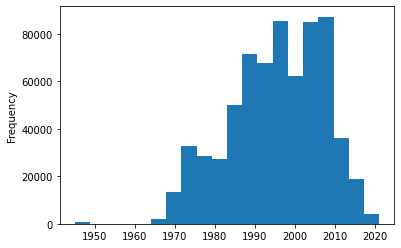

In [ ]:
train_df['建築年'].plot.hist(bins=20)

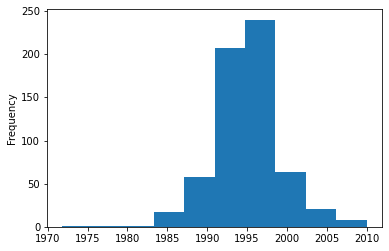

In [ ]:
train_df.groupby(['都道府県名', '市区町村名'])['建築年'].mean().plot.hist()
# 都道府県名と市区町村名でグループ化すると建築年は一定の広がりを持つ

In [ ]:
len(train_df) / len(train_df.groupby(['都道府県名', '市区町村名'])['建築年'])

1119.357027463651

In [ ]:
# 1 グループ平均 1100 件程度あり、平均値にも一定の確からしさがありそう
# よって建築年の NA 値は 都道府県名・市区町村名でグループ化した結果を使う

In [ ]:
# 地区名まで込みでグループ化するとどうなるかも気になる

In [ ]:
train_df.corr()

,ID,市区町村コード,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log
ID,1.000000,0.999942,-0.010064,0.055634,0.001248,-0.156123
市区町村コード,0.999942,1.000000,-0.009522,0.055914,0.001133,-0.157309
建築年,-0.010064,-0.009522,1.000000,0.129314,0.146005,0.539753
建ぺい率（％）,0.055634,0.055914,0.129314,1.000000,0.768723,0.025427
容積率（％）,0.001248,0.001133,0.146005,0.768723,1.000000,0.112121
取引価格（総額）_log,-0.156123,-0.157309,0.539753,0.025427,0.112121,1.000000


In [ ]:
set(train_df.keys()) - set(train_df._get_numeric_data().keys())

{'今後の利用目的',
 '取引の事情等',
 '取引時点',
 '地区名',
 '市区町村名',
 '建物の構造',
 '改装',
 '最寄駅：名称',
 '最寄駅：距離（分）',
 '用途',
 '種類',
 '都市計画',
 '都道府県名',
 '間取り',
 '面積（㎡）'}

In [ ]:
train_df.groupby('都市計画')['建築年']

In [ ]:
constructed_year_dict = dict(train_df.groupby(['都道府県名', '市区町村名'])['建築年'].mean())
constructed_year_dict[('秋田県', '秋田市')]

1995.1297709923665

In [ ]:
def set_mean(row):
  return constructed_year_dict[(row['都道府県名'], row['市区町村名'])]

In [ ]:
# 以下はボツ案
# for key, value in constructed_year_dict.items():
#   train_df[ (train_df['都道府県名'] == key[0]) & (train_df['市区町村名'] == key[1])]['建築年'] = train_df[ (train_df['都道府県名'] == key[0]) & (train_df['市区町村名'] == key[1])]['建築年'].fillna(constructed_year_dict[(key[0], key[1])])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# これがこのノートの目玉！
import numpy as np
for idx, row in train_df.iterrows():
  if pd.isnull(row['建築年']):
    train_df.at[idx, '建築年'] = constructed_year_dict[(row['都道府県名'], row['市区町村名'])]

In [ ]:
import numpy as np
for idx, row in test_df.iterrows():
  if pd.isnull(row['建築年']):
    test_df.at[idx, '建築年'] = constructed_year_dict[(row['都道府県名'], row['市区町村名'])]

In [ ]:
for key in na_contained_keys:
  most_presented_index = train_df[key].value_counts().index[0]
  train_df[key] = train_df[key].fillna(most_presented_index)

In [ ]:
na_contained_test_keys = [key for key in test_df.keys() if len(test_df[test_df[key].isnull()]) > 0]

In [ ]:
for key in na_contained_test_keys:
  most_presented_index = test_df[key].value_counts().index[0]
  test_df[key] = test_df[key].fillna(most_presented_index)

In [ ]:
# とりあえず一番多い値で NA を埋める作戦
# for val in train_df.keys():
#   label_for_fill = train_df[val].value_counts().sort_values(ascending=False).keys()[0]
#   train_df[val] = train_df[val].fillna(label_for_fill)

In [ ]:
# for val in test_df.keys():
#   label_for_fill = test_df[val].value_counts().sort_values(ascending=False).keys()[0]
#   test_df[val] = test_df[val].fillna(label_for_fill)

In [ ]:
train_df['取引時点_何年前'] = train_df['取引時点'].apply(lambda x: 2021-int(x[:4]))
test_df['取引時点_何年前'] = test_df['取引時点'].apply(lambda x: 2021-int(x[:4]))

In [ ]:
def normalize_area(area):
    if area == area:
        area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
    return area

In [ ]:
import re
train_df['面積（㎡）'] = train_df['面積（㎡）'].apply(lambda x: normalize_area(x))
test_df['面積（㎡）'] = test_df['面積（㎡）'].apply(lambda x: normalize_area(x))

ModuleNotFoundError: ignored

In [ ]:
train_df.head()

,ID,種類,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,取引時点_何年前
0,9047697,中古マンション等,9201,栃木県,宇都宮市,本丸町,東武宇都宮,18,３ＬＤＫ,70,2001.000000,ＳＲＣ,住宅,住宅,商業地域,80.0,400.0,2013年第3四半期,未改装,調停・競売等,7.146128,8
1,9024322,中古マンション等,9213,栃木県,那須塩原市,塩原,西那須野,2H?,３ＬＤＫ,30,1997.513812,ＲＣ,住宅,住宅,市街化区域及び市街化調整区域外の都市計画区域,60.0,200.0,2017年第4四半期,未改装,調停・競売等,6.000000,4
2,9033185,中古マンション等,9202,栃木県,足利市,新山町,足利,26,３ＬＤＫ,65,1998.000000,ＳＲＣ,住宅,住宅,第１種住居地域,60.0,200.0,2014年第1四半期,改装済,調停・競売等,7.380211,7
3,9063857,中古マンション等,9208,栃木県,小山市,駅東通り,小山,6,３ＬＤＫ,75,2006.000000,ＲＣ,住宅,住宅,商業地域,80.0,400.0,2009年第3四半期,未改装,調停・競売等,7.230449,12
4,9001815,中古マンション等,9201,栃木県,宇都宮市,桜,東武宇都宮,18,３ＬＤＫ,75,1997.342404,ＲＣ,住宅,住宅,商業地域,80.0,400.0,2018年第3四半期,未改装,調停・競売等,7.342423,3


In [ ]:
!pip install xfeat

     |████████████████████████████████| 308 kB 8.4 MB/s 
     |████████████████████████████████| 81 kB 10.0 MB/s 
     |████████████████████████████████| 210 kB 57.3 MB/s 
     |████████████████████████████████| 75 kB 4.8 MB/s 
     |████████████████████████████████| 113 kB 53.7 MB/s 
     |████████████████████████████████| 49 kB 6.4 MB/s 
     |████████████████████████████████| 150 kB 58.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=6421ba6000052097e6c6f25a9a85a0e55bbf848ade2aa05c6d5c5304e59dd9b7
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
  Created wheel for ml-metrics: filename=ml_metrics-0.1.4-py3-none-any.whl size=7845 sha256=5e1cea3fed87647c4454c7c47deeb10abbdcfe3c3befc61f6300b2168afb1b11
  Stored in directory: /root/.cache/pip/wheels/56/41/5b/0c6d42b3604a5c823d8922564c4708f84962fa7f2f4facfa6d
Successfully built pyperclip ml-metrics


In [ ]:
from xfeat import LabelEncoder, SelectCategorical, SelectNumerical, ArithmeticCombinations, Pipeline

In [ ]:
encoder = Pipeline(
    [
        SelectNumerical(),
        ArithmeticCombinations(
            input_cols=["面積（㎡）", "容積率（％）"], 
            drop_origin=True, 
            operator="*", 
            r=2,
        ),
    ]
)

num_comb_train_df = encoder.fit_transform(train_df)/100
num_comb_test_df = encoder.fit_transform(test_df)/100

In [ ]:
def normalize_moyori(moyori):
    if moyori == moyori:
        if moyori == '30分?60分':
            moyori = 45
        elif moyori == '1H?1H30':
            moyori = 75
        elif moyori == '1H30?2H':
            moyori = 105
        elif moyori == '2H?':
            moyori = 120
        moyori = int(float(moyori))
    return moyori

In [ ]:
train_df['最寄駅：距離（分）'] = train_df['最寄駅：距離（分）'].apply(lambda x: normalize_moyori(x))
test_df['最寄駅：距離（分）'] = test_df['最寄駅：距離（分）'].apply(lambda x: normalize_moyori(x))

In [ ]:
from xfeat import aggregation
agg_dfs_train = []
agg_dfs_test = []

def get_agg_df(df, group_col):
    agg_df, agg_cols = aggregation(df,
                        group_key=group_col,
                        group_values=['最寄駅：距離（分）', '面積（㎡）', '建ぺい率（％）', '容積率（％）'],
                        agg_methods=['count', 'mean', 'min', 'max'],
                        )

    return agg_df[agg_cols]

In [ ]:
group_col = '市区町村名'
agg_dfs_train.append(get_agg_df(train_df, group_col))
agg_dfs_test.append(get_agg_df(test_df, group_col))

In [ ]:
agg_dfs_train

[        agg_count_最寄駅：距離（分）_grpby_市区町村名  ...  agg_max_容積率（％）_grpby_市区町村名
 0                                  1397  ...                       700.0
 1                                   200  ...                       400.0
 2                                   145  ...                       700.0
 3                                   245  ...                       500.0
 4                                  1397  ...                       700.0
 ...                                 ...  ...                         ...
 692877                             1105  ...                       700.0
 692878                             1105  ...                       700.0
 692879                             1105  ...                       700.0
 692880                             1105  ...                       700.0
 692881                             1105  ...                       700.0
 
 [692882 rows x 16 columns]]

In [ ]:
train_df = pd.concat([train_df, num_comb_train_df]+agg_dfs_train, axis=1)
test_df = pd.concat([test_df, num_comb_test_df]+agg_dfs_test, axis=1)

In [ ]:
encoder = Pipeline([
    SelectCategorical(),
    LabelEncoder(output_suffix=""),
])

le_train_df = encoder.fit_transform(train_df)

In [ ]:
num_train_df = SelectNumerical().fit_transform(train_df)

In [ ]:
num_train_df.head()

,ID,市区町村コード,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_何年前,面積（㎡）容積率（％）_combi,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_count_面積（㎡）_grpby_市区町村名,agg_count_建ぺい率（％）_grpby_市区町村名,agg_count_容積率（％）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_mean_面積（㎡）_grpby_市区町村名,agg_mean_建ぺい率（％）_grpby_市区町村名,agg_mean_容積率（％）_grpby_市区町村名,agg_min_最寄駅：距離（分）_grpby_市区町村名,agg_min_面積（㎡）_grpby_市区町村名,agg_min_建ぺい率（％）_grpby_市区町村名,agg_min_容積率（％）_grpby_市区町村名,agg_max_最寄駅：距離（分）_grpby_市区町村名,agg_max_面積（㎡）_grpby_市区町村名,agg_max_建ぺい率（％）_grpby_市区町村名,agg_max_容積率（％）_grpby_市区町村名
0,9047697,9201,18,70,2001.000000,80.0,400.0,7.146128,8,280.0,1397,1397,1397,1397,16.725841,59.352183,71.152470,319.327130,0,10,60.0,150.0,45,175,80.0,700.0
1,9024322,9213,120,30,1997.513812,60.0,200.0,6.000000,4,60.0,200,200,200,200,70.390000,49.050000,71.400000,312.500000,2,25,60.0,200.0,120,95,80.0,400.0
2,9033185,9202,26,65,1998.000000,60.0,200.0,7.380211,7,130.0,145,145,145,145,11.820690,57.655172,63.724138,233.793103,1,20,60.0,200.0,75,115,80.0,700.0
3,9063857,9208,6,75,2006.000000,80.0,400.0,7.230449,12,300.0,245,245,245,245,10.355102,63.142857,73.551020,324.489796,2,30,60.0,200.0,45,100,80.0,500.0
4,9001815,9201,18,75,1997.342404,80.0,400.0,7.342423,3,300.0,1397,1397,1397,1397,16.725841,59.352183,71.152470,319.327130,0,10,60.0,150.0,45,175,80.0,700.0


In [ ]:
le_test_df = encoder.fit_transform(test_df)

In [ ]:
num_test_df = SelectNumerical().fit_transform(test_df)

In [ ]:
num_test_df.head()

,ID,市区町村コード,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引時点_何年前,面積（㎡）容積率（％）_combi,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_count_面積（㎡）_grpby_市区町村名,agg_count_建ぺい率（％）_grpby_市区町村名,agg_count_容積率（％）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_mean_面積（㎡）_grpby_市区町村名,agg_mean_建ぺい率（％）_grpby_市区町村名,agg_mean_容積率（％）_grpby_市区町村名,agg_min_最寄駅：距離（分）_grpby_市区町村名,agg_min_面積（㎡）_grpby_市区町村名,agg_min_建ぺい率（％）_grpby_市区町村名,agg_min_容積率（％）_grpby_市区町村名,agg_max_最寄駅：距離（分）_grpby_市区町村名,agg_max_面積（㎡）_grpby_市区町村名,agg_max_建ぺい率（％）_grpby_市区町村名,agg_max_容積率（％）_grpby_市区町村名
0,1000001,1101,25,85,1989.0,40.0,80.0,0,68.0,251,251,251,251,10.498008,68.685259,73.944223,335.697211,1,15,40.0,80.0,45,210,80.0,800.0
1,1000002,1101,20,105,1997.0,80.0,200.0,0,210.0,251,251,251,251,10.498008,68.685259,73.944223,335.697211,1,15,40.0,80.0,45,210,80.0,800.0
2,1000066,1101,3,50,2012.0,80.0,600.0,0,300.0,251,251,251,251,10.498008,68.685259,73.944223,335.697211,1,15,40.0,80.0,45,210,80.0,800.0
3,1000119,1101,2,45,1991.0,80.0,400.0,0,180.0,251,251,251,251,10.498008,68.685259,73.944223,335.697211,1,15,40.0,80.0,45,210,80.0,800.0
4,1000120,1101,4,55,1980.0,80.0,300.0,0,165.0,251,251,251,251,10.498008,68.685259,73.944223,335.697211,1,15,40.0,80.0,45,210,80.0,800.0


In [ ]:
train_target = train_df['取引価格（総額）_log']

In [ ]:
train_df = train_df.drop('取引価格（総額）_log', axis=1)

In [ ]:
num_train_df

,ID,市区町村コード,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_何年前,面積（㎡）容積率（％）_combi,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_count_面積（㎡）_grpby_市区町村名,agg_count_建ぺい率（％）_grpby_市区町村名,agg_count_容積率（％）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_mean_面積（㎡）_grpby_市区町村名,agg_mean_建ぺい率（％）_grpby_市区町村名,agg_mean_容積率（％）_grpby_市区町村名,agg_min_最寄駅：距離（分）_grpby_市区町村名,agg_min_面積（㎡）_grpby_市区町村名,agg_min_建ぺい率（％）_grpby_市区町村名,agg_min_容積率（％）_grpby_市区町村名,agg_max_最寄駅：距離（分）_grpby_市区町村名,agg_max_面積（㎡）_grpby_市区町村名,agg_max_建ぺい率（％）_grpby_市区町村名,agg_max_容積率（％）_grpby_市区町村名
0,9047697,9201,18,70,2001.000000,80.0,400.0,7.146128,8,280.0,1397,1397,1397,1397,16.725841,59.352183,71.152470,319.327130,0,10,60.0,150.0,45,175,80.0,700.0
1,9024322,9213,120,30,1997.513812,60.0,200.0,6.000000,4,60.0,200,200,200,200,70.390000,49.050000,71.400000,312.500000,2,25,60.0,200.0,120,95,80.0,400.0
2,9033185,9202,26,65,1998.000000,60.0,200.0,7.380211,7,130.0,145,145,145,145,11.820690,57.655172,63.724138,233.793103,1,20,60.0,200.0,75,115,80.0,700.0
3,9063857,9208,6,75,2006.000000,80.0,400.0,7.230449,12,300.0,245,245,245,245,10.355102,63.142857,73.551020,324.489796,2,30,60.0,200.0,45,100,80.0,500.0
4,9001815,9201,18,75,1997.342404,80.0,400.0,7.342423,3,300.0,1397,1397,1397,1397,16.725841,59.352183,71.152470,319.327130,0,10,60.0,150.0,45,175,80.0,700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692877,45030246,45201,18,75,1998.000000,80.0,400.0,7.079181,6,300.0,1105,1105,1105,1105,20.427149,67.140271,66.470588,258.624434,0,15,50.0,80.0,120,140,80.0,700.0
692878,45031710,45201,20,105,2006.000000,80.0,400.0,7.518514,9,420.0,1105,1105,1105,1105,20.427149,67.140271,66.470588,258.624434,0,15,50.0,80.0,120,140,80.0,700.0
692879,45046528,45201,6,55,1979.000000,80.0,600.0,6.612784,13,330.0,1105,1105,1105,1105,20.427149,67.140271,66.470588,258.624434,0,15,50.0,80.0,120,140,80.0,700.0
692880,45022529,45201,18,85,2000.000000,60.0,200.0,7.176091,11,170.0,1105,1105,1105,1105,20.427149,67.140271,66.470588,258.624434,0,15,50.0,80.0,120,140,80.0,700.0


In [ ]:
# axis=1 が重要っぽい
le_num_train = pd.concat([le_train_df, num_train_df], axis=1)

In [ ]:
le_num_test = pd.concat([le_test_df, num_test_df], axis=1)

In [ ]:
le_num_train = le_num_train.drop('取引価格（総額）_log', axis=1)

In [ ]:
le_num_train

,種類,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,取引時点,改装,取引の事情等,ID,市区町村コード,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引時点_何年前,面積（㎡）容積率（％）_combi,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_count_面積（㎡）_grpby_市区町村名,agg_count_建ぺい率（％）_grpby_市区町村名,agg_count_容積率（％）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_mean_面積（㎡）_grpby_市区町村名,agg_mean_建ぺい率（％）_grpby_市区町村名,agg_mean_容積率（％）_grpby_市区町村名,agg_min_最寄駅：距離（分）_grpby_市区町村名,agg_min_面積（㎡）_grpby_市区町村名,agg_min_建ぺい率（％）_grpby_市区町村名,agg_min_容積率（％）_grpby_市区町村名,agg_max_最寄駅：距離（分）_grpby_市区町村名,agg_max_面積（㎡）_grpby_市区町村名,agg_max_建ぺい率（％）_grpby_市区町村名,agg_max_容積率（％）_grpby_市区町村名
0,0,0,0,0,0,0,0,0,0,0,0,0,0,9047697,9201,18,70,2001.000000,80.0,400.0,8,280.0,1397,1397,1397,1397,16.725841,59.352183,71.152470,319.327130,0,10,60.0,150.0,45,175,80.0,700.0
1,0,0,1,1,1,0,1,0,0,1,1,0,0,9024322,9213,120,30,1997.513812,60.0,200.0,4,60.0,200,200,200,200,70.390000,49.050000,71.400000,312.500000,2,25,60.0,200.0,120,95,80.0,400.0
2,0,0,2,2,2,0,0,0,0,2,2,1,0,9033185,9202,26,65,1998.000000,60.0,200.0,7,130.0,145,145,145,145,11.820690,57.655172,63.724138,233.793103,1,20,60.0,200.0,75,115,80.0,700.0
3,0,0,3,3,3,0,1,0,0,0,3,0,0,9063857,9208,6,75,2006.000000,80.0,400.0,12,300.0,245,245,245,245,10.355102,63.142857,73.551020,324.489796,2,30,60.0,200.0,45,100,80.0,500.0
4,0,0,0,4,0,0,1,0,0,0,4,0,0,9001815,9201,18,75,1997.342404,80.0,400.0,3,300.0,1397,1397,1397,1397,16.725841,59.352183,71.152470,319.327130,0,10,60.0,150.0,45,175,80.0,700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692877,0,46,616,12093,3847,0,0,0,0,0,42,1,0,45030246,45201,18,75,1998.000000,80.0,400.0,6,300.0,1105,1105,1105,1105,20.427149,67.140271,66.470588,258.624434,0,15,50.0,80.0,120,140,80.0,700.0
692878,0,46,616,681,3845,6,1,0,0,0,39,0,0,45031710,45201,20,105,2006.000000,80.0,400.0,9,420.0,1105,1105,1105,1105,20.427149,67.140271,66.470588,258.624434,0,15,50.0,80.0,120,140,80.0,700.0
692879,0,46,616,12086,3845,1,3,0,0,0,52,1,0,45046528,45201,6,55,1979.000000,80.0,600.0,13,330.0,1105,1105,1105,1105,20.427149,67.140271,66.470588,258.624434,0,15,50.0,80.0,120,140,80.0,700.0
692880,0,46,616,12078,3847,4,1,0,0,8,32,0,0,45022529,45201,18,85,2000.000000,60.0,200.0,11,170.0,1105,1105,1105,1105,20.427149,67.140271,66.470588,258.624434,0,15,50.0,80.0,120,140,80.0,700.0


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(le_num_train, train_target, test_size=0.3, random_state=42)

In [ ]:
import lightgbm as lgb

In [ ]:
model = lgb.LGBMRegressor(random_state=42, n_estimators=100)
model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test), (X_train, y_train)],
)
lgb.plot_metric

[1]	training's l2: 0.110812	valid_0's l2: 0.112124
[2]	training's l2: 0.0987874	valid_0's l2: 0.100036
[3]	training's l2: 0.0884412	valid_0's l2: 0.0896411
[4]	training's l2: 0.07968	valid_0's l2: 0.0808756
[5]	training's l2: 0.0727977	valid_0's l2: 0.0739659
[6]	training's l2: 0.0666553	valid_0's l2: 0.0678066
[7]	training's l2: 0.061566	valid_0's l2: 0.0626816
[8]	training's l2: 0.0572389	valid_0's l2: 0.0583299
[9]	training's l2: 0.0535146	valid_0's l2: 0.0545924
[10]	training's l2: 0.0505289	valid_0's l2: 0.0515884
[11]	training's l2: 0.0477103	valid_0's l2: 0.0487501
[12]	training's l2: 0.0454287	valid_0's l2: 0.0464577
[13]	training's l2: 0.0434223	valid_0's l2: 0.0444454
[14]	training's l2: 0.041734	valid_0's l2: 0.0427644
[15]	training's l2: 0.0401652	valid_0's l2: 0.0411766
[16]	training's l2: 0.0387893	valid_0's l2: 0.0397789
[17]	training's l2: 0.0375664	valid_0's l2: 0.0385592
[18]	training's l2: 0.0365306	valid_0's l2: 0.0375172
[19]	training's l2: 0.0356354	valid_0's l2: 

<function lightgbm.plotting.plot_metric>

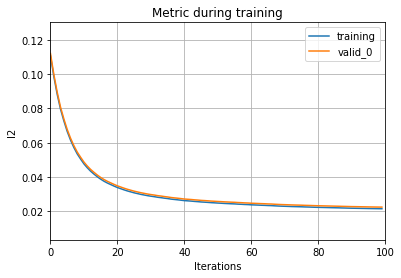

In [ ]:
lgb.plot_metric(model)

In [ ]:
# metric 見ると itration 足りていないような気がする

In [ ]:
le_num_test

,種類,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,取引時点,改装,取引の事情等,ID,市区町村コード,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引時点_何年前,面積（㎡）容積率（％）_combi,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_count_面積（㎡）_grpby_市区町村名,agg_count_建ぺい率（％）_grpby_市区町村名,agg_count_容積率（％）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_mean_面積（㎡）_grpby_市区町村名,agg_mean_建ぺい率（％）_grpby_市区町村名,agg_mean_容積率（％）_grpby_市区町村名,agg_min_最寄駅：距離（分）_grpby_市区町村名,agg_min_面積（㎡）_grpby_市区町村名,agg_min_建ぺい率（％）_grpby_市区町村名,agg_min_容積率（％）_grpby_市区町村名,agg_max_最寄駅：距離（分）_grpby_市区町村名,agg_max_面積（㎡）_grpby_市区町村名,agg_max_建ぺい率（％）_grpby_市区町村名,agg_max_容積率（％）_grpby_市区町村名
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1000001,1101,25,85,1989.0,40.0,80.0,0,68.0,251,251,251,251,10.498008,68.685259,73.944223,335.697211,1,15,40.0,80.0,45,210,80.0,800.0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,1000002,1101,20,105,1997.0,80.0,200.0,0,210.0,251,251,251,251,10.498008,68.685259,73.944223,335.697211,1,15,40.0,80.0,45,210,80.0,800.0
2,0,0,0,1,1,1,0,0,0,2,0,0,0,1000066,1101,3,50,2012.0,80.0,600.0,0,300.0,251,251,251,251,10.498008,68.685259,73.944223,335.697211,1,15,40.0,80.0,45,210,80.0,800.0
3,0,0,0,1,2,2,1,0,0,2,0,0,0,1000119,1101,2,45,1991.0,80.0,400.0,0,180.0,251,251,251,251,10.498008,68.685259,73.944223,335.697211,1,15,40.0,80.0,45,210,80.0,800.0
4,0,0,0,1,2,1,1,0,0,1,0,0,0,1000120,1101,4,55,1980.0,80.0,300.0,0,165.0,251,251,251,251,10.498008,68.685259,73.944223,335.697211,1,15,40.0,80.0,45,210,80.0,800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22390,0,46,528,5904,1144,5,0,0,0,1,0,0,0,47006237,47211,4,75,2019.0,80.0,300.0,0,225.0,7,7,7,7,4.000000,68.571429,67.142857,228.571429,4,60,60.0,200.0,4,90,80.0,300.0
22391,0,46,528,3448,1144,1,0,0,0,6,0,0,0,47006258,47211,4,65,2018.0,60.0,200.0,0,130.0,7,7,7,7,4.000000,68.571429,67.142857,228.571429,4,60,60.0,200.0,4,90,80.0,300.0
22392,0,46,528,5905,1144,5,0,0,0,1,0,0,0,47006316,47211,4,65,2010.0,80.0,300.0,0,195.0,7,7,7,7,4.000000,68.571429,67.142857,228.571429,4,60,60.0,200.0,4,90,80.0,300.0
22393,0,46,528,5906,1144,5,0,0,0,6,0,0,0,47006474,47211,4,60,2017.0,60.0,200.0,0,120.0,7,7,7,7,4.000000,68.571429,67.142857,228.571429,4,60,60.0,200.0,4,90,80.0,300.0


In [ ]:
test_pred = model.predict(le_num_test)

In [ ]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1 MB 5.3 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=220a59032cd29948d2c594460f5f08ac086a7b46060afcc19c727bc8a9b60bac
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [ ]:
import japanize_matplotlib

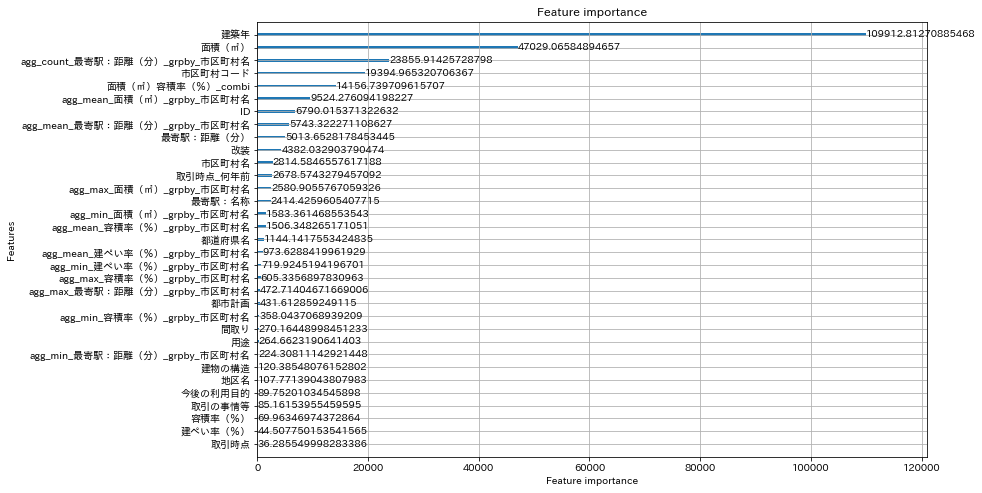

In [ ]:
lgb.plot_importance(model, figsize=(12, 8), max_num_features=50, importance_type='gain')

In [ ]:
!ls

data_explanation.xlsx  __MACOSX     sample_submission.csv  train
data.zip	       sample_data  test.csv		   train.zip


In [ ]:
sub_df = pd.read_csv('./sample_submission.csv')

In [ ]:
test_df['取引価格（総額）_log'] = test_pred

In [ ]:
test_df

,ID,種類,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引時点_何年前,面積（㎡）容積率（％）_combi,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_count_面積（㎡）_grpby_市区町村名,agg_count_建ぺい率（％）_grpby_市区町村名,agg_count_容積率（％）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_mean_面積（㎡）_grpby_市区町村名,agg_mean_建ぺい率（％）_grpby_市区町村名,agg_mean_容積率（％）_grpby_市区町村名,agg_min_最寄駅：距離（分）_grpby_市区町村名,agg_min_面積（㎡）_grpby_市区町村名,agg_min_建ぺい率（％）_grpby_市区町村名,agg_min_容積率（％）_grpby_市区町村名,agg_max_最寄駅：距離（分）_grpby_市区町村名,agg_max_面積（㎡）_grpby_市区町村名,agg_max_建ぺい率（％）_grpby_市区町村名,agg_max_容積率（％）_grpby_市区町村名,取引価格（総額）_log
0,1000001,中古マンション等,1101,北海道,札幌市中央区,旭ケ丘,円山公園,25,４ＬＤＫ,85,1989.0,ＲＣ,住宅,住宅,第１種低層住居専用地域,40.0,80.0,2021年第1四半期,未改装,調停・競売等,0,68.0,251,251,251,251,10.498008,68.685259,73.944223,335.697211,1,15,40.0,80.0,45,210,80.0,800.0,6.841153
1,1000002,中古マンション等,1101,北海道,札幌市中央区,旭ケ丘,円山公園,20,４ＬＤＫ,105,1997.0,ＲＣ,住宅,住宅,近隣商業地域,80.0,200.0,2021年第1四半期,未改装,調停・競売等,0,210.0,251,251,251,251,10.498008,68.685259,73.944223,335.697211,1,15,40.0,80.0,45,210,80.0,800.0,7.166781
2,1000066,中古マンション等,1101,北海道,札幌市中央区,大通西,西１１丁目,3,２ＬＤＫ,50,2012.0,ＲＣ,住宅,住宅,商業地域,80.0,600.0,2021年第1四半期,未改装,調停・競売等,0,300.0,251,251,251,251,10.498008,68.685259,73.944223,335.697211,1,15,40.0,80.0,45,210,80.0,800.0,7.395942
3,1000119,中古マンション等,1101,北海道,札幌市中央区,大通西,西１８丁目,2,１ＬＤＫ,45,1991.0,ＳＲＣ,住宅,住宅,商業地域,80.0,400.0,2021年第1四半期,未改装,調停・競売等,0,180.0,251,251,251,251,10.498008,68.685259,73.944223,335.697211,1,15,40.0,80.0,45,210,80.0,800.0,6.779769
4,1000120,中古マンション等,1101,北海道,札幌市中央区,大通西,西１８丁目,4,２ＬＤＫ,55,1980.0,ＳＲＣ,住宅,住宅,近隣商業地域,80.0,300.0,2021年第1四半期,未改装,調停・競売等,0,165.0,251,251,251,251,10.498008,68.685259,73.944223,335.697211,1,15,40.0,80.0,45,210,80.0,800.0,6.634324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22390,47006237,中古マンション等,47211,沖縄県,沖縄市,字美里,川崎,4,３ＬＤＫ,75,2019.0,ＲＣ,住宅,住宅,近隣商業地域,80.0,300.0,2021年第1四半期,未改装,調停・競売等,0,225.0,7,7,7,7,4.000000,68.571429,67.142857,228.571429,4,60,60.0,200.0,4,90,80.0,300.0,7.446806
22391,47006258,中古マンション等,47211,沖縄県,沖縄市,美里,川崎,4,２ＬＤＫ,65,2018.0,ＲＣ,住宅,住宅,第１種中高層住居専用地域,60.0,200.0,2021年第1四半期,未改装,調停・競売等,0,130.0,7,7,7,7,4.000000,68.571429,67.142857,228.571429,4,60,60.0,200.0,4,90,80.0,300.0,7.385341
22392,47006316,中古マンション等,47211,沖縄県,沖縄市,美原,川崎,4,３ＬＤＫ,65,2010.0,ＲＣ,住宅,住宅,近隣商業地域,80.0,300.0,2021年第1四半期,未改装,調停・競売等,0,195.0,7,7,7,7,4.000000,68.571429,67.142857,228.571429,4,60,60.0,200.0,4,90,80.0,300.0,7.328026
22393,47006474,中古マンション等,47211,沖縄県,沖縄市,与儀,川崎,4,３ＬＤＫ,60,2017.0,ＲＣ,住宅,住宅,第１種中高層住居専用地域,60.0,200.0,2021年第1四半期,未改装,調停・競売等,0,120.0,7,7,7,7,4.000000,68.571429,67.142857,228.571429,4,60,60.0,200.0,4,90,80.0,300.0,7.318380


In [ ]:
sub_df = pd.merge(sub_df['ID'], test_df[['ID', '取引価格（総額）_log']], on='ID')
sub_df.to_csv('test_submission.csv', index=False)

In [ ]:
from google.colab import files
files.download('test_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# おまけの eda

In [ ]:
train_df['都道府県名'].unique()

47

In [ ]:
sum = train_df['都道府県名'].value_counts().sum()

In [ ]:
train_df['都道府県名'].value_counts() / sum

東京都     0.300742
神奈川県    0.142334
大阪府     0.113078
兵庫県     0.061149
埼玉県     0.060377
千葉県     0.051866
愛知県     0.047861
福岡県     0.046992
北海道     0.033837
京都府     0.023541
宮城県     0.015482
静岡県     0.010068
広島県     0.008325
奈良県     0.007495
新潟県     0.005429
滋賀県     0.005201
茨城県     0.005095
大分県     0.004119
岡山県     0.003887
熊本県     0.003777
愛媛県     0.002999
栃木県     0.002921
山口県     0.002876
沖縄県     0.002876
福島県     0.002830
香川県     0.002827
鹿児島県    0.002820
長崎県     0.002683
三重県     0.002630
群馬県     0.002572
石川県     0.002559
岐阜県     0.002065
岩手県     0.002015
長野県     0.001840
宮崎県     0.001774
富山県     0.001403
和歌山県    0.001217
秋田県     0.001155
青森県     0.001098
徳島県     0.000940
佐賀県     0.000914
鳥取県     0.000854
山梨県     0.000836
山形県     0.000792
福井県     0.000776
高知県     0.000603
島根県     0.000469
Name: 都道府県名, dtype: float64

In [ ]:
pref = train_df['都道府県名']

In [ ]:
pref.value_counts() - pref.value_counts()[0]

東京都          0
神奈川県   -109758
大阪府    -130029
兵庫県    -166010
埼玉県    -166545
千葉県    -172442
愛知県    -175217
福岡県    -175819
北海道    -184934
京都府    -192068
宮城県    -197652
静岡県    -201403
広島県    -202611
奈良県    -203186
新潟県    -204617
滋賀県    -204775
茨城県    -204849
大分県    -205525
岡山県    -205686
熊本県    -205762
愛媛県    -206301
栃木県    -206355
山口県    -206386
沖縄県    -206386
福島県    -206418
香川県    -206420
鹿児島県   -206425
長崎県    -206520
三重県    -206557
群馬県    -206597
石川県    -206606
岐阜県    -206948
岩手県    -206983
長野県    -207104
宮崎県    -207150
富山県    -207407
和歌山県   -207536
秋田県    -207579
青森県    -207618
徳島県    -207728
佐賀県    -207746
鳥取県    -207787
山梨県    -207800
山形県    -207830
福井県    -207841
高知県    -207961
島根県    -208054
Name: 都道府県名, dtype: int64

In [ ]:
import numpy as np
arr = np.arange(12.)
arr = arr.reshape(3,4)

array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.]])

In [ ]:
arr_b = arr.reshape(3,4)

In [ ]:
dic = {'a': {'hoge': 1}, 'b': {'hoge': 2} }

In [ ]:
df1 = pd.DataFrame(dic)

In [ ]:
dic2 = {'c': {'fuga': 1}, 'd': {'fuga': 2} }

In [ ]:
df2 = pd.DataFrame(dic2)

In [ ]:
df1.add(df2, fill_value=0)

,a,b,c,d
fuga,NaN,NaN,1.0,2.0
hoge,1.0,2.0,NaN,NaN


In [ ]:
df1

,a,b
hoge,1,2


In [ ]:
def get_mid(x):
  return (x.max() + x.min())/2.

In [ ]:
arr = np.arange(12.).reshape(3, 4)

In [ ]:
arr

array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.]])

In [ ]:
df1 = pd.DataFrame(arr, index=['one', 'two', 'three'])

In [ ]:
df1.apply(get_mid)

0    4.0
1    5.0
2    6.0
3    7.0
dtype: float64

In [ ]:
def max_min(x):
  return pd.Series([x.max(), x.min()], index=['max', 'min'])

In [ ]:
df1.apply(max_min)

,0,1,2,3
max,8.0,9.0,10.0,11.0
min,0.0,1.0,2.0,3.0


In [ ]:
def inverse(x):
  return -x

In [ ]:
df1.loc['one'].map(inverse)

0   -0.0
1   -1.0
2   -2.0
3   -3.0
Name: one, dtype: float64

In [ ]:
inverse_2 = lambda x: -x

In [ ]:
df1.loc['two'].map(inverse_2)

0   -4.0
1   -5.0
2   -6.0
3   -7.0
Name: two, dtype: float64

In [ ]:
series = pd.Series([1, 2, 3, np.nan], index=['one', 'two', 'three', 'four'])

In [ ]:
series.sort_values(ascending=False)

three    3.0
two      2.0
one      1.0
four     NaN
dtype: float64

In [ ]:
series.rank().sort_values()

one      1.0
two      2.0
three    3.0
five     4.5
six      4.5
four     NaN
dtype: float64

In [ ]:
series.diff()

one      NaN
two      1.0
three    1.0
four     NaN
five     NaN
six      0.0
dtype: float64

In [ ]:
series2 = pd.Series(np.arange(12.))

In [ ]:
mask = series2.isin([1.0])

In [ ]:
series2[mask]

1    1.0
dtype: float64

In [ ]:
series.rename(index=str.title)

One      1.0
Two      2.0
Three    3.0
Four     NaN
Five     5.0
Six      5.0
dtype: float64

In [ ]:
import pandas as pd
series = pd.Series([1, 13, 45, 56, 65, 78, 90, 119])

In [ ]:
bins = [10, 30, 50, 70]

In [ ]:
cuts = pd.cut(series, bins, labels=['a', 'nice middle', 'eldery'])

In [ ]:
cuts

0            NaN
1              a
2    nice middle
3         eldery
4         eldery
5            NaN
6            NaN
7            NaN
dtype: category
Categories (3, object): ['a' < 'nice middle' < 'eldery']

In [ ]:
pd.value_counts(cuts)

eldery         2
a              1
nice middle    1
dtype: int64

In [ ]:
import numpy as np
data = np.random.rand(20) * 3

In [ ]:
data

array([2.46726297, 1.24863711, 2.64672836, 0.58968781, 2.89220246,
       0.37785258, 1.46146509, 0.16966466, 1.55434521, 0.88172867,
       2.56079551, 0.98555674, 2.44617475, 1.42266506, 0.82820656,
       1.71749615, 2.24996288, 1.52680794, 1.42097844, 0.95923699])

In [ ]:
pd.cut(data, 4, precision=1)

[(2.2, 2.9], (0.9, 1.5], (2.2, 2.9], (0.2, 0.9], (2.2, 2.9], ..., (1.5, 2.2], (2.2, 2.9], (0.9, 1.5], (0.9, 1.5], (0.9, 1.5]]
Length: 20
Categories (4, interval[float64, right]): [(0.2, 0.9] < (0.9, 1.5] < (1.5, 2.2] < (2.2, 2.9]]

In [ ]:
qcuts = pd.qcut(data, 4)

In [ ]:
pd.value_counts(qcuts)

(0.169, 0.94]     5
(0.94, 1.442]     5
(1.442, 2.299]    5
(2.299, 2.892]    5
dtype: int64

In [ ]:
data = pd.DataFrame(np.random.randn(1000, 4))

In [ ]:
data.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.010609,-0.075229,0.038223,0.009474
std,1.003674,1.002200,0.982868,1.009563
min,-3.798512,-3.695153,-2.896794,-3.139132
25%,-0.657002,-0.784343,-0.575353,-0.663719
50%,0.030310,-0.097463,0.034243,-0.027147
75%,0.720417,0.592781,0.702586,0.659517
max,3.166961,2.806704,3.012190,3.813772


In [ ]:
col = data[2]

In [ ]:
col[col > 1]

0      2.401605
4      1.314399
6      1.379700
20     2.081438
24     1.165238
         ...   
962    1.608379
971    2.111434
976    1.325463
978    1.145945
996    2.586280
Name: 2, Length: 162, dtype: float64

In [ ]:
sampler = np.random.permutation(5)

In [ ]:
sampler

array([2, 3, 1, 0, 4])

In [ ]:
df = pd.DataFrame(np.arange(5 * 4).reshape(5, 4))

In [ ]:
df.take(sampler)

,0,1,2,3
2,8,9,10,11
3,12,13,14,15
1,4,5,6,7
0,0,1,2,3
4,16,17,18,19


In [ ]:
df.sample(n=3)

,0,1,2,3
0,0,1,2,3
2,8,9,10,11
1,4,5,6,7


In [ ]:
df = pd.DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'b'], 'data1': range(6)}) 

In [ ]:
df

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,b,5


In [ ]:
pd.get_dummies(df['key'])

,a,b,c
0,0,1,0
1,0,1,0
2,1,0,0
3,0,0,1
4,1,0,0
5,0,1,0


In [ ]:
dummies = pd.get_dummies(df['key'], prefix='key')

In [ ]:
df_with_dummy = df[['data1']].join(dummies)

In [ ]:
df_with_dummy

,data1,key_a,key_b,key_c
0,0,0,1,0
1,1,0,1,0
2,2,1,0,0
3,3,0,0,1
4,4,1,0,0
5,5,0,1,0
